In [1]:
import psycopg2
from psycopg2 import sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [2]:

conn = psycopg2.connect(
    dbname="PI3",
    user="postgres",
    password="123456",
    host="127.0.0.1",
    port="5432"
)
cur = conn.cursor()

query = """SELECT * FROM vendas_fato ORDER BY data_venda"""

# Executar a consulta
cur.execute(query)

# Obter os resultados
rows = cur.fetchall()

# Obter os nomes das colunas
colnames = [desc[0] for desc in cur.description]

# Fechar a conexão
cur.close()
conn.close()

# Armazenar os resultados em um DataFrame
dados = pd.DataFrame(rows, columns=colnames)

dados.head()

,prod_id,loja_id,forma_pgmt_id,cliente_id,quantidade,imposto_5_percent,total,data_venda,hora,cogs,renda_bruta,margem_bruta_percent
0,838,2,1,11,6,8.77,184.09,2019-01-01,11:40:00,175.32,8.77,4.76
1,697,1,1,9,4,5.41,113.57,2019-01-01,20:26:00,108.16,5.41,4.76
2,18,1,3,27,6,21.78,457.44,2019-01-01,10:39:00,435.66,21.78,4.76
3,828,1,3,24,10,37.11,779.31,2019-01-01,14:42:00,742.20,37.11,4.76
4,524,2,2,5,2,6.29,132.03,2019-01-01,11:43:00,125.74,6.29,4.76


In [3]:
# Substitua 'data' pelo nome correto da coluna de datas
dados['data_venda'] = pd.to_datetime(dados['data_venda'])

# Definir a coluna de data como índice
dados.set_index('data_venda', inplace=True)

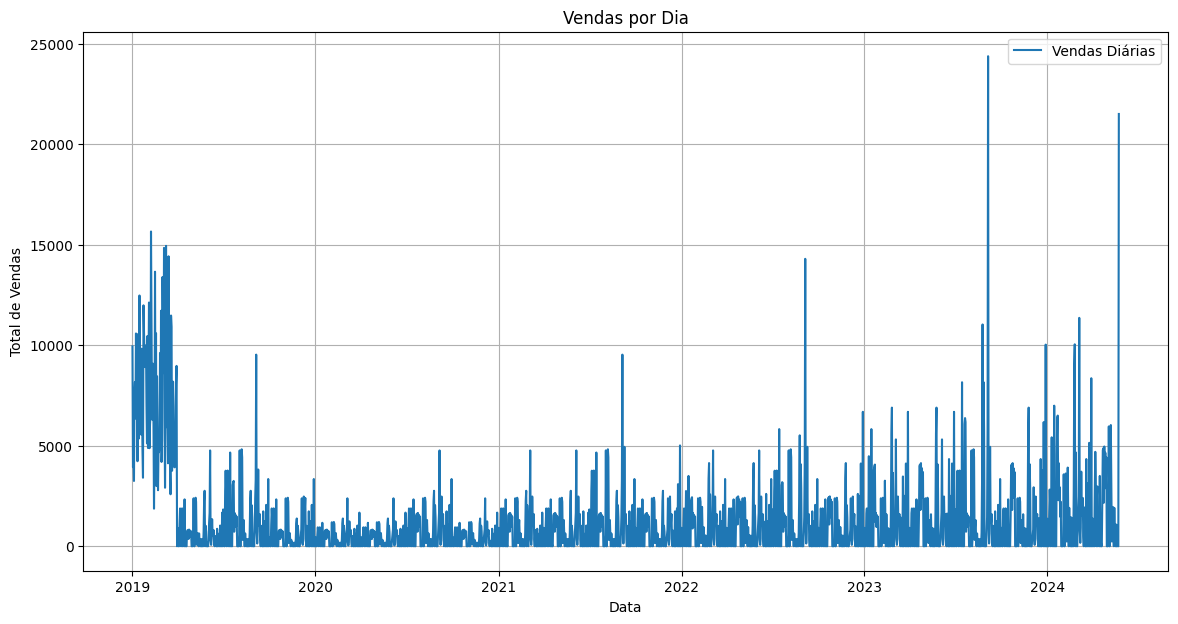

In [4]:
# Agrupar as vendas por dia
vendas_diarias = dados['total'].resample('D').sum()
vendas_semanal = dados['total'].resample('W').sum()
vendas_mensal = dados['total'].resample('M').sum()
# Plotar o gráfico de vendas por dia
plt.figure(figsize=(14, 7))
plt.plot(vendas_diarias, label='Vendas Diárias')
plt.title('Vendas por Dia')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.legend()
plt.grid(True)
plt.show()

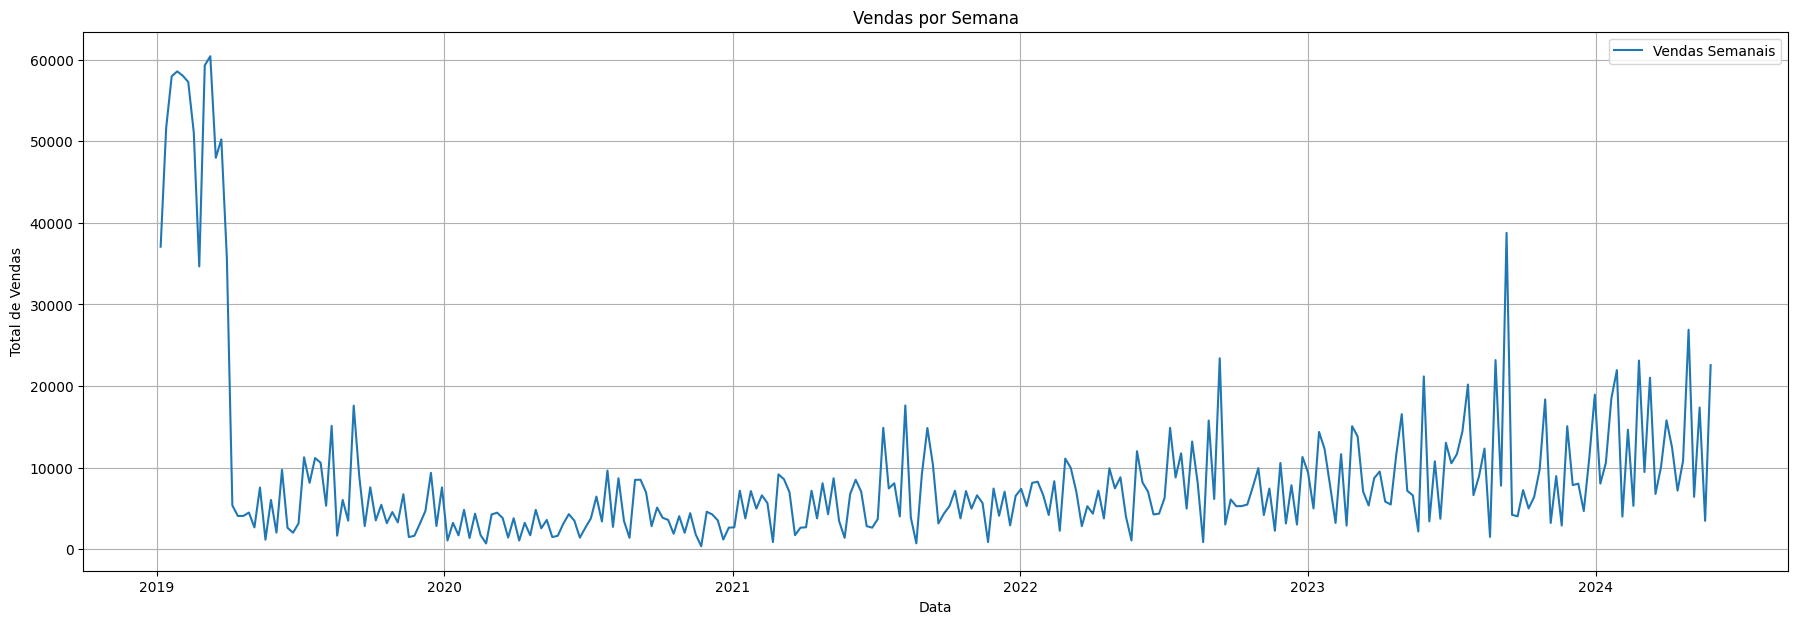

In [28]:
# Plotar o gráfico de vendas por dia
plt.figure(figsize=(22, 7))
plt.plot(vendas_semanal, label='Vendas Semanais')
plt.title('Vendas por Semana')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.legend()
plt.grid(True)
plt.show()

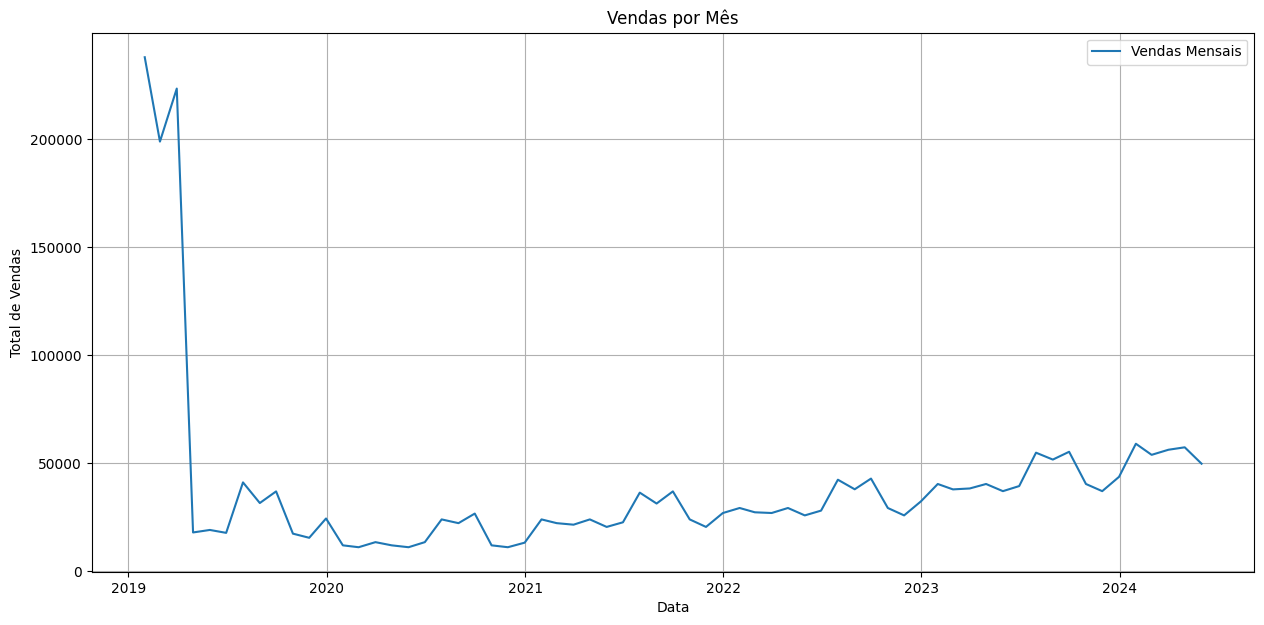

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(vendas_mensal, label='Vendas Mensais')
plt.title('Vendas por Mês')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Instanciar o normalizador
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalizar os dados de vendas mensais
vendas_mensal_normalized = scaler.fit_transform(
    vendas_mensal.values.reshape(-1, 1))

# Converter os dados normalizados para um array numpy
vendas_mensal_array = vendas_mensal_normalized.flatten()

# Verifique os dados normalizados
print(vendas_mensal_array[:5])

[1.         0.82781786 0.93603526 0.03013564 0.03525074]


In [7]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


# Definir o comprimento da sequência
sequence_length = 12

# Criar sequências
X, y = create_sequences(vendas_mensal_array, sequence_length)

# Verificar as formas das sequências de entrada e saída
print(X.shape, y.shape)

(53, 12) (53,)


In [8]:
# Dividindo os dados em conjuntos de treinamento e teste (80% treino, 20% teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Verificando os shapes após a divisão
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(42, 12) (11, 12) (42,) (11,)


In [9]:
# Criando o modelo MLP para prever séries temporais
model = MLPRegressor(hidden_layer_sizes=(
    50,), activation='relu', solver='adam', max_iter=500)

# Treinando o modelo
model.fit(X_train, y_train)

# Avaliando o modelo
y_pred = model.predict(X_test)

# Verificando a performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.001884306352811497


In [10]:
# Prever as vendas do próximo mês
last_sequence = vendas_mensal_array[-sequence_length:]
next_month_prediction = model.predict([last_sequence])
next_month_prediction = scaler.inverse_transform([next_month_prediction])

print(f"Previsão de vendas para o próximo mês: {next_month_prediction[0][0]}")

Previsão de vendas para o próximo mês: 40446.204708970705


In [18]:
future_predictions = []
for _ in range(8):
    next_pred = model.predict([last_sequence])
    future_predictions.append(next_pred[0])
    last_sequence = np.append(last_sequence[1:], next_pred[0])

# Inverter a normalização das previsões
future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1))

# Criar um novo índice de datas para os próximos 3 meses
future_dates = pd.date_range(
    start=vendas_mensal.index[-1] + pd.DateOffset(months=1), periods=8, freq='M')

# Criar um DataFrame para as previsões futuras
future_df = pd.DataFrame(
    future_predictions, index=future_dates, columns=['Previsão'])


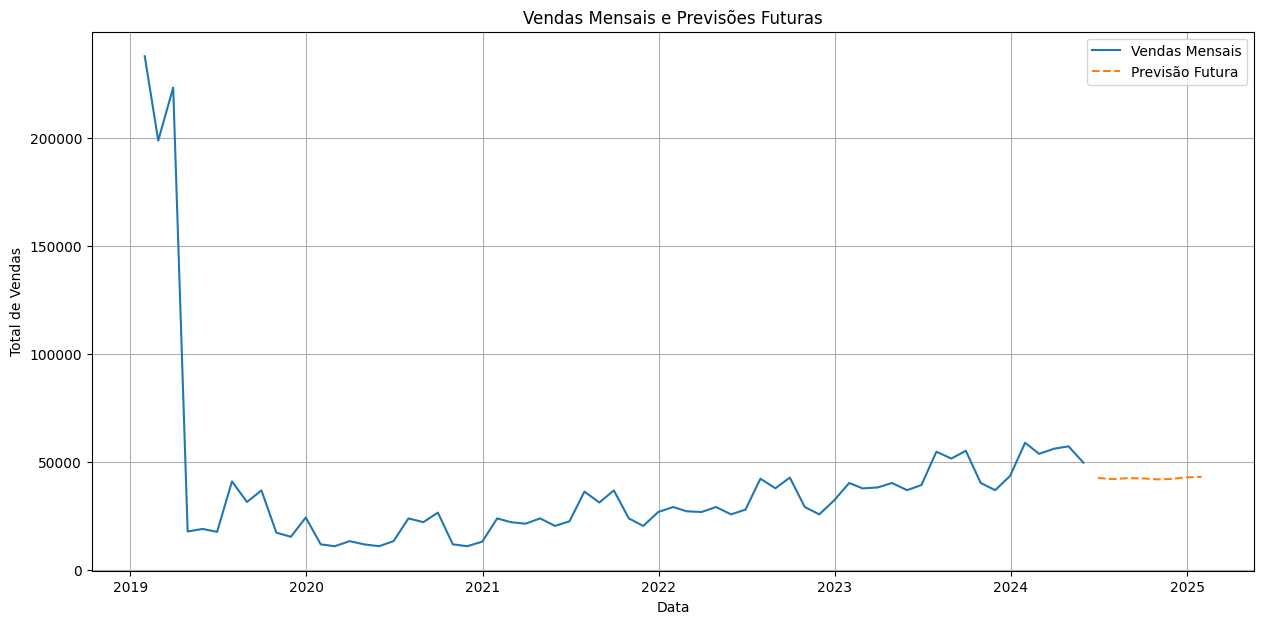

In [19]:
# Plotar o gráfico de vendas passadas e previsões futuras
plt.figure(figsize=(15, 7))
plt.plot(vendas_mensal, label='Vendas Mensais')
plt.plot(future_df, label='Previsão Futura', linestyle='--')
plt.title('Vendas Mensais e Previsões Futuras')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Converter a coluna de data para datetime
dados['Data'] = pd.to_datetime(dados['Data'], format='%m/%d/%Y')



# Conectar ao banco de dados PostgreSQL
conn = psycopg2.connect(
    dbname="PI3",
    user="postgres",
    password="123456",
    host="127.0.0.1",
    port="5432"
)
cur = conn.cursor()


# Inserir dados na tabela
for index, row in dados.iterrows():
    cur.execute(sql.SQL("""
        INSERT INTO vendas (
            loja_filia, loja_cidade, cliente_tipo, cliente_gen, prod_linha, prod_preco, 
            quantidade, imposto_5_percent, total, data_venda, hora, forma_pgmt_desc, 
            cogs, margem_bruta_percent, renda_bruta, avaliacao, cliente_nome
        ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """), (
        row['Filial'], row['Cidade'], row['Tipo de Cliente'], row['Gênero'], row['Linha de Produto'], row['Preço Unitário'],
        row['Quantidade'], row['Imposto 5%'], row['Total'], row['Data'], row['Hora'], row['Pagamento'],
        row['COGS'], row['Margem Bruta (%)'], row['Renda Bruta'], row['Avaliação'], row['Nome']
    ))

# Confirmar e fechar a conexão
conn.commit()
cur.close()
conn.close()